In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout,LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1, l2
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Setup Data

In [6]:
data = pd.read_csv("./data/newEra.csv")

data.head()

,timeStamps,bufferSizes,bufferingStates,bufferingEvents,newBitrates,oldBitrates,resolutions,streamBandwidths,estimatedBandwidths
0,2024-09-18 02:27:43,1.0,1,5.290,2096000,1196000,960p,2.0,4.4
1,2024-09-18 02:27:46,1.0,1,6.509,2096000,1196000,960p,2.0,5.0
2,2024-09-18 02:27:47,1.0,0,6.509,2096000,1196000,960p,2.0,5.0
3,2024-09-18 02:27:48,1.0,0,6.509,2096000,1196000,960p,2.0,6.4
4,2024-09-18 02:27:49,1.0,0,6.509,2096000,1196000,960p,2.0,6.4


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timeStamps           1337 non-null   object 
 1   bufferSizes          1337 non-null   float64
 2   bufferingStates      1337 non-null   int64  
 3   bufferingEvents      1337 non-null   float64
 4   newBitrates          1337 non-null   int64  
 5   oldBitrates          1337 non-null   int64  
 6   resolutions          1337 non-null   object 
 7   streamBandwidths     1337 non-null   float64
 8   estimatedBandwidths  1337 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 94.1+ KB


In [8]:
data['timeStamps'] = pd.to_datetime(data['timeStamps'])
data.dtypes
data.set_index('timeStamps', inplace=True)
data

,bufferSizes,bufferingStates,bufferingEvents,newBitrates,oldBitrates,resolutions,streamBandwidths,estimatedBandwidths
timeStamps,,,,,,,,
2024-09-18 02:27:43,1.0,1,5.290000,2096000,1196000,960p,2.0,4.4
2024-09-18 02:27:46,1.0,1,6.509000,2096000,1196000,960p,2.0,5.0
2024-09-18 02:27:47,1.0,0,6.509000,2096000,1196000,960p,2.0,5.0
2024-09-18 02:27:48,1.0,0,6.509000,2096000,1196000,960p,2.0,6.4
2024-09-18 02:27:49,1.0,0,6.509000,2096000,1196000,960p,2.0,6.4
...,...,...,...,...,...,...,...,...
2024-09-18 03:22:32,1.0,1,2009.692001,6096000,4596000,1920p,5.9,8.1
2024-09-18 03:22:33,0.5,0,2009.692001,6096000,4596000,1920p,5.9,8.4
2024-09-18 03:22:34,1.0,0,2009.692001,6096000,4596000,1920p,5.9,8.4


In [9]:
encoder = LabelEncoder()
data['resolutions'] = encoder.fit_transform(data['resolutions'])

In [10]:
features = data[["resolutions","estimatedBandwidths","streamBandwidths"]]
target = data['newBitrates']  # Target

In [11]:
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))
# Normalisasi data
train_features, test_features, train_target, test_target = train_test_split(
    features_scaled, target_scaled, test_size=0.2, shuffle=False,random_state=42)

print("train features",train_features.shape)
print("train target",train_target.shape)

train features (1069, 3)
train target (1069, 1)


In [12]:
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)



In [13]:
sequence_length = 20
X_train, y_train = create_sequences(train_features, train_target, sequence_length)
X_test, y_test = create_sequences(test_features, test_target, sequence_length)

In [14]:
print("X_train" ,X_train.shape)
print("y_train" ,y_train.shape)

print("X_test" ,X_test.shape)
print("y_test" ,y_test.shape)

X_train (1049, 20, 3)
y_train (1049, 1)
X_test (248, 20, 3)
y_test (248, 1)


In [15]:
def build_model(X_train):
     # Define the model
     model = Sequential()

# LSTM layer
     model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
     model.add(Dropout(0.2))

# LSTM layer kedua
     model.add(LSTM(units=50))
     model.add(Dropout(0.2))

# Output layer (regression)
     model.add(Dense(units=1))

# Compile the model
     model.compile(optimizer='adam', loss='mean_squared_error')
     model.summary()
     return model




In [16]:
model = build_model(X_train)

d:\cursor_code\python\Lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,435 (404.04 KB)

 Trainable params: 103,435 (404.04 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.2233 - val_loss: 0.0054
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0549 - val_loss: 0.0091
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0467 - val_loss: 0.0135
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0511 - val_loss: 0.0141
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0393 - val_loss: 0.0068
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0409 - val_loss: 0.0058
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0328 - val_loss: 0.0048
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0421 - val_loss: 0.0054
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0310 - val_loss: 0.0047
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0313 - val_loss: 0.0040
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0324 - val_loss: 0.0052
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

In [18]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)

# Predicting the test set results
y_pred = model.predict(X_test)
y_pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0124
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


array([[0.96278834],
       [0.97330225],
       [0.97116196],
       [0.96642256],
       [0.964297  ],
       [0.9642919 ],
       [0.9656221 ],
       [0.9678109 ],
       [0.9705259 ],
       [0.9734741 ],
       [1.002439  ],
       [0.98810387],
       [0.94261783],
       [0.96840274],
       [0.9872183 ],
       [0.99120224],
       [1.0190233 ],
       [0.9834891 ],
       [0.9822878 ],
       [1.0005153 ],
       [1.0011157 ],
       [1.0009892 ],
       [1.0026866 ],
       [1.0025911 ],
       [1.0006797 ],
       [0.946836  ],
       [0.9613936 ],
       [0.97093874],
       [0.9698124 ],
       [0.966075  ],
       [0.31587234],
       [0.21873628],
       [0.2595858 ],
       [0.3314532 ],
       [0.3622591 ],
       [0.367683  ],
       [0.6962693 ],
       [0.7735344 ],
       [0.7677223 ],
       [0.76507175],
       [0.7786374 ],
       [0.97385657],
       [0.99988395],
       [0.9759002 ],
       [0.967544  ],
       [0.9551103 ],
       [0.9558424 ],
       [0.959

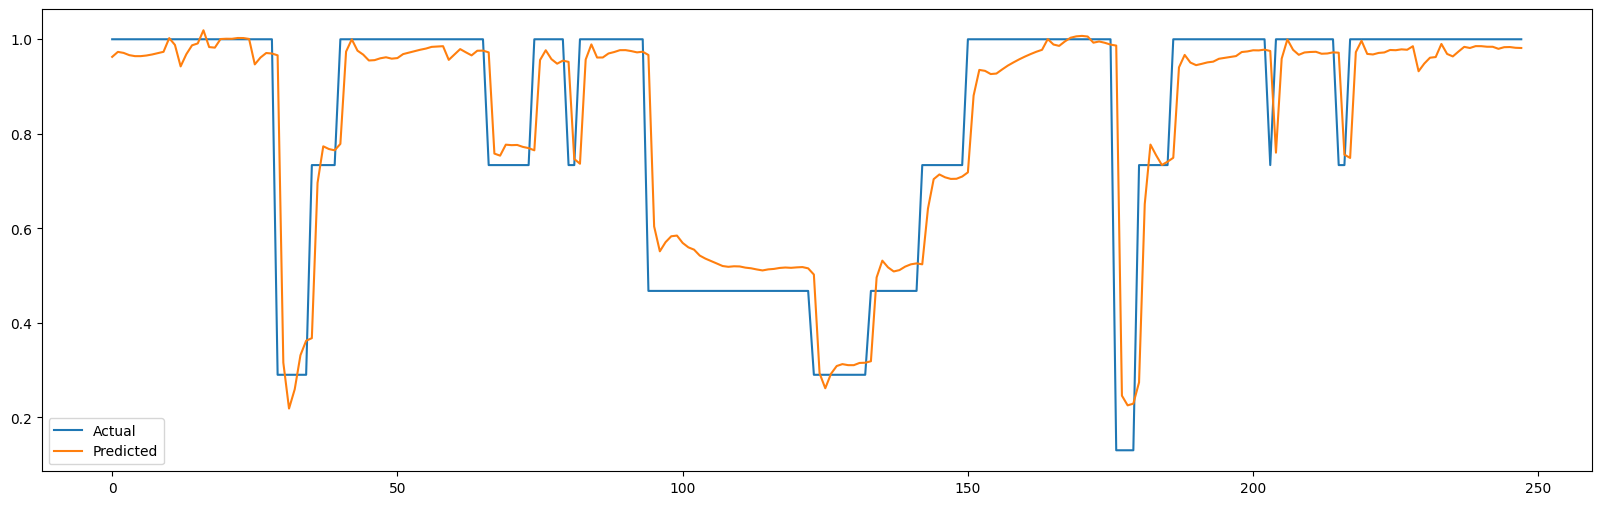

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


0.8193985142647168

In [22]:
from sklearn.metrics import mean_absolute_error

mae = np.square(mean_absolute_error(y_test, y_pred))
mean = np.square(mean_squared_error(y_pred, y_test))
r2 = r2_score(y_test, y_pred)

# Menampilkan hasil

print("Mean Absolute Error (MAE):", mae)

print("Mean Squared Error (MSE):", mean)

print("R-squared (R2):", r2)



Mean Absolute Error (MAE): 0.0032995927212403696
Mean Squared Error (MSE): 0.0001437681289258221
R-squared (R2): 0.8193985142647168
